In [ ]:
# model = models.vgg13(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG13_Weights.IMAGENET1K_V1`. You can also use `weights=VGG13_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [1]:
# 운영 체제와 상호 작용하는 함수(예: 파일 처리)를 불러옴.
import os

# 시간 관련 함수(예: 시간 측정)를 불러옴.
import time

# 객체를 깊은 복사(deep copy)하기 위한 모듈을 불러옴.
import copy

# NumPy 라이브러리를 np 별칭으로 불러옴. 배열 및 수치 연산에 사용함.
import numpy as np

# Matplotlib의 pyplot 모듈을 plt 별칭으로 불러옴. 데이터 시각화에 사용함.
import matplotlib.pyplot as plt

# PyTorch 핵심 라이브러리를 불러옴.
import torch

# TorchVision 라이브러리를 불러옴.
import torchvision

# 신경망 레이어(nn) 모듈을 불러옴.
import torch.nn as nn

# 옵티마이저(optim) 모듈을 불러옴.
import torch.optim as optim

# 학습률 스케줄러(lr_scheduler) 모듈을 불러옴. 학습률 조정에 사용함.
from torch.optim import lr_scheduler

# TorchVision에서 데이터셋, 미리 학습된 모델, 데이터 변환 모듈을 불러옴.
from torchvision import datasets, models, transforms

# PyTorch의 난수 생성기 시드(seed) 값을 0으로 설정했음. 재현성을 보장함.
torch.manual_seed(0)

In [ ]:
# 파일 업로드 창이 열립니다. 여기서 kaggle.json 파일을 선택하여 업로드합니다.
# from google.colab import files
# files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hansikyung","key":"1d58e4a8071660387131eac2257216c0"}'}

In [ ]:
# !pip install kaggle

# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# !kaggle datasets download -d ajayrana/hymenoptera-data
# !unzip -q hymenoptera-data.zip -d .

Dataset URL: https://www.kaggle.com/datasets/ajayrana/hymenoptera-data
License(s): CC0-1.0
  0% 0.00/90.2M [00:00<?, ?B/s]
100% 90.2M/90.2M [00:00<00:00, 1.69GB/s]


In [2]:
ddir = '/home/kim/Desktop/AI_cours/hymenoptera_data'

# 학습(train)과 검증(val) 데이터셋에 적용할 이미지 전처리(transform)를 딕셔너리로 정의함.
data_transformers = {
    # 학습 데이터 변환: 데이터 증강(Augmentation) 포함함.
    'train': transforms.Compose([
        # 이미지를 무작위로 자르고 224x224로 조절함.
        transforms.RandomResizedCrop(224),
        # 이미지를 무작위로 수평 뒤집음.
        transforms.RandomHorizontalFlip(),
        # 이미지를 PyTorch 텐서로 변환함.
        transforms.ToTensor(),
        # 텐서를 채널별 평균과 표준편차를 사용하여 정규화함.
        transforms.Normalize([0.490, 0.449, 0.411], [0.231, 0.221, 0.230])
    ]),
    # 검증 데이터 변환: 크기 조정과 정규화만 포함함.
    'val': transforms.Compose([
        # 이미지를 256 크기로 조절함.
        transforms.Resize(256),
        # 이미지 중앙을 224x224 크기로 자름.
        transforms.CenterCrop(224),
        # 이미지를 PyTorch 텐서로 변환함.
        transforms.ToTensor(),
        # 학습 데이터와 동일하게 정규화를 적용함.
        transforms.Normalize([0.490, 0.449, 0.411], [0.231, 0.221, 0.230])
    ])}

# 'train'과 'val' 디렉토리에서 ImageFolder 데이터셋을 로드하고 해당 전처리를 적용함.
img_data = {k: datasets.ImageFolder(os.path.join(ddir, k), data_transformers[k]) for k in ['train', 'val']}

# ImageFolder 데이터셋을 DataLoader 객체로 변환함.
# 배치 크기 8, 데이터 섞기(shuffle) 활성화, 작업자 수(num_workers)는 2로 설정함.
dloaders = {'train': torch.utils.data.DataLoader(img_data['train'], batch_size=8, shuffle=True, num_workers=2),
             'val': torch.utils.data.DataLoader(img_data['val'], batch_size=8, shuffle=False, num_workers=2)}

# 학습 및 검증 데이터셋 전체 이미지 개수(사이즈) 저장함
dset_sizes = {x: len(img_data[x]) for x in {'train', 'val'}}

# 데이터셋에서 자동으로 추출된 클래스 이름 리스트로 저장
classes = img_data['train'].classes

# 학습에 사용할 장치(device)를 설정함.
dvc = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
import ast
with open('/home/kim/Desktop/AI_cours/강의_7기_AI응용_5차시_CNN 응용_재활용 분류 시스템/imagenet1000_clsidx_to_labels.txt') as f:
    classes_data = f.read()
classes_dict = ast.literal_eval(classes_data)
print({k: classes_dict[k] for k in list(classes_dict)[:5]})
# ast: 파일 내 문자열 파이썬 tree 구조를 파이썬 데이터 구조인 dict() 형태로 변환해줌

{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark'}


In [6]:
# 이미지를 화면에 표시하는 함수를 정의함. (정규화된 이미지를 역변환함)
def imageshow(img, text=None):
    # PyTorch 텐서를 NumPy 배열로 변환하고 채널 순서를 Matplotlib 형식으로 전치함.
    img = img.numpy().transpose((1, 2, 0))

    # 정규화에 사용했던 R, G, B 채널별 평균(mean)을 정의함.
    avg = np.array([0.490, 0.449, 0.411])

    # 정규화에 사용했던 R, G, B 채널별 표준편차(stddev)를 정의함.
    stddev = np.array([0.231, 0.221, 0.230])

    # 역정규화(denormalization)를 수행함.
    img = stddev * img + avg

    # 픽셀 값을 [0, 1] 범위 내로 클립(clip)함.
    img = np.clip(img, 0, 1)

    # Matplotlib을 사용하여 이미지를 화면에 표시함.
    plt.imshow(img)

    # 텍스트가 제공된 경우 이미지의 제목으로 설정함.
    if text is not None:
        plt.title(text)

# 학습된 모델의 예측 결과를 시각화하는 함수를 정의함.
def visualize_predictions(pretrained_model, max_num_imgs=4):
    # 난수 생성기 시드를 설정했음.
    torch.manual_seed(1)

    # 모델의 원래 학습 모드 상태를 저장함.
    was_model_training = pretrained_model.training

    # 모델을 평가 모드로 설정함.
    pretrained_model.eval()

    # 시각화할 이미지 카운터를 0으로 초기화함.
    imgs_counter = 0

    # Matplotlib 그림 객체(figure)를 생성함.
    fig = plt.figure()

    # 변화도(gradient) 계산을 비활성화함.
    with torch.no_grad():
        # 검증 데이터 로더('val')를 순회함.
        for i, (imgs, tgts) in enumerate(dloaders['val']):
            # 이미지와 정답 레이블을 장치(GPU/CPU)로 이동시킴. (이 부분에서 tgts가 사용되지 않고 있음)
            imgs = imgs.to(dvc)
            # tgts = tgts.to(dvc) # 주석: tgts는 현재 사용되지 않으나, GPU로 이동시키는 것이 일반적임.

            # 순전파를 수행하여 예측 결과(ops)를 얻음.
            ops = pretrained_model(imgs)

            # 예측 결과에서 예측 클래스(preds)를 찾음.
            _, preds = torch.max(ops, 1)

            # 현재 배치 내의 모든 이미지에 대해 순회함.
            for j in range(imgs.size()[0]):
                # 이미지 카운터를 증가시킴.
                imgs_counter += 1

                # 서브플롯 위치를 설정함.
                ax = plt.subplot(max_num_imgs//2, 2, imgs_counter)

                # 축(axis) 표시를 끔.
                ax.axis('off')

                # 예측 클래스 이름만 제목으로 설정함. (원래 정답 레이블(target)도 포함했으나 지금은 예측만 표시함)
                # classes_dict는 이전에 정의된 classes 변수와 동일할 것으로 예상함.
                ax.set_title(f'pred: {classes_dict[int(preds[j])]}')

                # 역정규화된 이미지를 화면에 표시함.
                imageshow(imgs.cpu().data[j])

                # 설정된 최대 이미지 수에 도달했다면
                if imgs_counter == max_num_imgs:
                    # 모델의 모드를 원래 상태로 되돌림.
                    pretrained_model.train(mode=was_model_training)
                    # 함수 실행을 종료함.
                    return
        # 루프를 끝까지 실행했다면 모델의 모드를 원래 상태로 되돌림.
        pretrained_model.train(mode=was_model_training)

In [7]:
model = models.vgg13(pretrained=True)
model = model.to(dvc)

/home/kim/miniconda3/envs/yolo_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kim/miniconda3/envs/yolo_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG13_Weights.IMAGENET1K_V1`. You can also use `weights=VGG13_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg13-19584684.pth" to /home/kim/.cache/torch/hub/checkpoints/vgg13-19584684.pth


100%|██████████| 508M/508M [00:09<00:00, 56.7MB/s] 


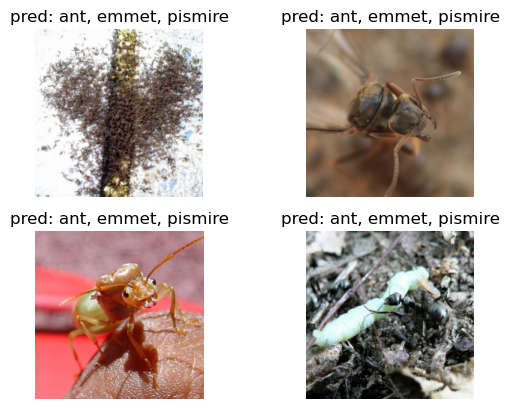

In [8]:
visualize_predictions(model)